In [1]:
# paper collect

In [3]:
from pathlib import Path
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

data_path = Path("./papers_info")
if not os.path.exists(data_path):
    os.mkdir(data_path)

conference = "iclr"
year = 2023

In [4]:
%%time
titles = []
abstracts = []
years = []
forum_ids = []
decisions = []
authors = []
keywords = []

#for year in [2018, 2019, 2020, 2021, 2022, 2023]:
for year in [2023]:
    for query in ['Blind_Submission', 'Withdrawn_Submission', 'Desk_Rejected_Submission']:
        url = f'https://api.openreview.net/notes?invitation=ICLR.cc%2F{year}%2FConference%2F-%2F{query}'
    
        for offset in [0, 1000, 2000, 3000, 4000]:
            df = pd.DataFrame(requests.get(url + f'&offset={offset}').json()['notes'])
            if len(df) > 0:
                titles    += [d['title'].strip() for d in df['content'].values]
                abstracts += [d['abstract'].strip() for d in df['content'].values]
                keywords  += [d['keywords'] for d in df['content'].values]
                authors   += [', '.join(d['authors']) for d in df['content']]
                years     += [year] * len(df)
                forum_ids += list(df.forum)
                                                
                if query == 'Withdrawn_Submission':
                    decisions += ['Withdrawn'] * len(df)
                elif query == 'Desk_Rejected_Submission':
                    decisions += ['Desk rejected'] * len(df)
                else:
                    decisions += [''] * len(df)
print('')
print(f'Found {len(titles)} papers')

iclr = pd.DataFrame.from_dict({
    'year': np.array(years).astype(int), 
    'id': forum_ids, 
    'title': titles, 
    'abstract': abstracts,
    'authors': authors,
    'decision': decisions,
    'scores': [[]] * len(abstracts),
    'keywords': [[kk.lower() for kk in k] for k in keywords],
})

mask = np.array([len(a) >= 200 for a in iclr.abstract])
iclr = iclr[mask].reset_index(drop=True)
print(f'Removing {np.sum(~mask)} submissions with abstract length below 200 characters.')


Found 4955 papers
Removing 0 submissions with abstract length below 200 characters.
CPU times: user 459 ms, sys: 39.9 ms, total: 498 ms
Wall time: 13.9 s


In [5]:
%%time

# Query the accept/reject decisions and scores. Warning: TAKES A COUPLE OF HOURS

for num, forum_id in enumerate(iclr.id):
    if (num + 1) % 1000 == 0:
        print('*', end='')
    elif (num + 1) % 100 == 0:
        print('.', end='')
        
    forum_url = f'https://api.openreview.net/notes?forum={forum_id}'
    json = requests.get(forum_url).json()

    if iclr.decision[num] == '':
        for i in range(len(json['notes'])):
            if 'decision' in json['notes'][i]['content']:
                decision = json['notes'][i]['content']['decision']
        iclr.at[num, 'decision'] = decision
        
    if iclr.decision[num] != 'Desk rejected':
        scores = []
        for i in range(len(json['notes'])):
            if iclr.year[num] < 2023:
                score_field = 'rating'
            else:
                score_field = 'recommendation'
            if score_field in json['notes'][i]['content']:
                score = int(json['notes'][i]['content'][score_field].split(':')[0])
                scores.append(score)
        iclr.at[num, 'scores'] = scores

print('')

iclr.to_pickle(data_path / f'{conference}_{year}.pickle.zip')

.........*.........*.........*.........*.........
CPU times: user 1min 25s, sys: 2.02 s, total: 1min 27s
Wall time: 51min 56s


In [7]:
iclr.shape

(4955, 8)


Found 4955 papers
CPU times: user 872 ms, sys: 133 ms, total: 1.01 s
Wall time: 29 s


Removing 0 submissions with abstract length below 200 characters.


.........*.........*.........*.........*.........
CPU times: user 2min 9s, sys: 9.35 s, total: 2min 19s
Wall time: 56min 23s


/Users/shun/Library/Caches/pypoetry/virtualenvs/papers-visualization-wtOSKkz2-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shun/Library/Caches/pypoetry/virtualenvs/papers-visualization-wtOSKkz2-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


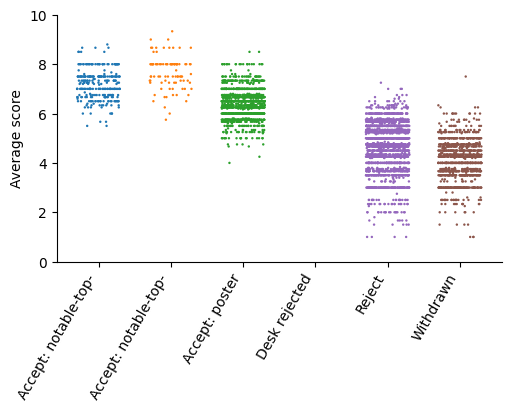

In [49]:
# Sanity check

fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')

avScores = np.array([np.mean(sc) for sc in iclr.scores])

np.random.seed(42)
for num, decision in enumerate(np.unique(iclr.decision)):
    mask = iclr.decision == decision
    ax.scatter(np.random.uniform(num-.3, num+.3, size=np.sum(mask)), avScores[mask], s=3, ec='none')

ax.set_ylim([0,10])
ax.set_ylabel('Average score')
ax.set_xticks(np.arange(np.unique(iclr.decision).size), 
              [d[:20] for d in np.unique(iclr.decision)], rotation=60, ha='right');

sns.despine()

,year,id,title,abstract,authors,decision,scores,keywords
0,2023,RUzSobdYy0V,Quantifying and Mitigating the Impact of Label...,Errors in labels obtained via human annotation...,"Julius Adebayo, Melissa Hall, Bowen Yu, Bobbie...",Accept: poster,"[5, 6, 8]",[]
1,2023,N3kGYG3ZcTi,Suppression helps: Lateral Inhibition-inspired...,Convolutional neural networks (CNNs) have beco...,"Chengyuan Zhuang, Xiaohui Yuan, XUAN GUO",Reject,"[3, 6, 3, 1]","[lateral inhibition, convolutional neural netw..."
2,2023,tmIiMPl4IPa,Factorized Fourier Neural Operators,We propose the Factorized Fourier Neural Opera...,"Alasdair Tran, Alexander Mathews, Lexing Xie, ...",Accept: poster,"[8, 6, 5, 8, 6]","[fourier transform, fourier operators, pde, na..."
3,2023,mhnHqRqcjYU,DFPC: Data flow driven pruning of coupled chan...,"Modern, multi-branched neural network architec...","Tanay Narshana, Chaitanya Murti, Chiranjib Bha...",Accept: poster,"[8, 6, 6]","[pruning, data free, model compression]"
4,2023,sZI1Oj9KBKy,TVSPrune - Pruning Non-discriminative filters ...,"Achieving structured, data-free sparsity of de...","Chaitanya Murti, Tanay Narshana, Chiranjib Bha...",Accept: poster,"[8, 6, 8, 3]","[structured pruning, model compression]"


In [ ]:
# visualize by tsne
iclr = pd.read_pickle(data_path / 'iclr_2023.pickle.zip')

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [75]:
titles_abstracts_together = [iclr.title[i] + ' ' + iclr.abstract[i] for i in range(len(iclr))]

vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(titles_abstracts_together)

tfidf_features.shape

(4955, 20753)

In [76]:
%%time

# SVD

from sklearn.decomposition import TruncatedSVD

# I tried 50, 100, 300, 600 components, and also not using SVD at all.
# 100 components give the most visually "clustered" t-SNE result
# See below

svd = TruncatedSVD(n_components=100, random_state=42, algorithm='arpack')
svd_data = svd.fit_transform(tfidf_features)

svd_data.shape

CPU times: user 4.02 s, sys: 1.15 s, total: 5.17 s
Wall time: 7.77 s


(4955, 100)

In [81]:
from sklearn.manifold import TSNE

In [82]:
%%time
papers_embed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(svd_data)

CPU times: user 1min 35s, sys: 2.95 s, total: 1min 38s
Wall time: 14.2 s


In [99]:
papers_embed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(tfidf_features)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


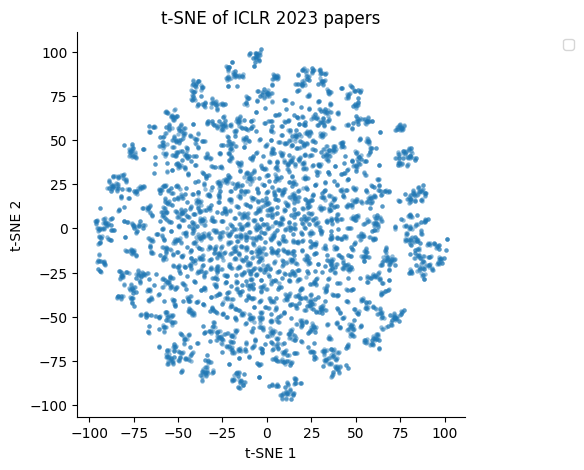

In [92]:
fig,ax = plt.subplots(figsize=(5,5))
# seabornを使ってpapers_embedをプロット
#sns.scatterplot(x=papers_embed[:,0], y=papers_embed[:,1], hue=iclr.decision, s=10, linewidth=0, alpha=0.5, ax=ax)
sns.scatterplot(x=papers_embed[:,0], y=papers_embed[:,1], s=10, linewidth=0, alpha=0.5, ax=ax)
ax.set_title('t-SNE of ICLR 2023 papers')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=1)
sns.despine()


In [93]:
# papers_embedをn=10でクラスタリング
from sklearn.cluster import KMeans

# 10 clusters
kmeans = KMeans(n_clusters=10, random_state=42).fit(papers_embed)

/Users/shun/Library/Caches/pypoetry/virtualenvs/papers-visualization-wtOSKkz2-py3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


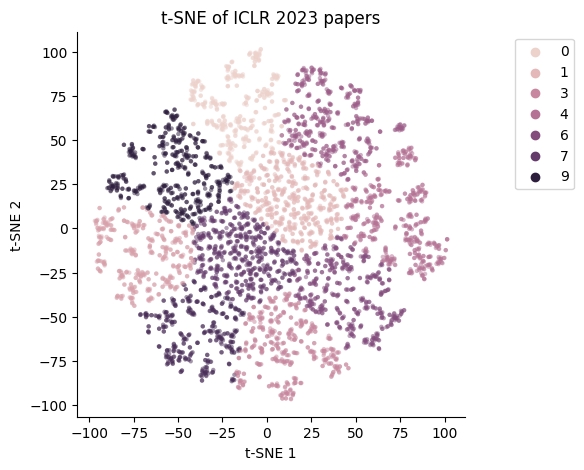

In [98]:
# クラスタリング結果をプロット
fig,ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=papers_embed[:,0], y=papers_embed[:,1], hue=kmeans.labels_, s=10, linewidth=0, alpha=0.5, ax=ax)
ax.set_title('t-SNE of ICLR 2023 papers')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=1)
sns.despine()
